In [274]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from copy import deepcopy
from time import time
import matplotlib.patches as mpatches
from time import sleep
import os


from isls import iSLS
from isls.utils import get_double_integrator_AB, plot_robot, plot_robot_base
from isls.projections import *
from isls.plot_utils import  plot_car

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
np.set_printoptions(precision=5, suppress=False)
plt.rcParams["figure.figsize"] = (4,3)
real_min = np.finfo(float).tiny

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [275]:
from autograd import elementwise_grad
def elementwise_jacobian2(f,x):
    return np.stack([elementwise_grad(lambda xx: f(xx)[:, j])(x) for j in range(f(x).shape[-1])], axis=1)
def elementwise_jacobian(f):
    return (lambda xx: elementwise_jacobian2(f, xx))

## Problem parameters

Set `x_dim`, `u_dim` and `N` according to your problem

In [276]:
## Set these parameters 
x_dim = 4   # Dimension of the state 
u_dim = 2   # Dimension of the control
T     = 15. # Duration in seconds
N     = 500 # Number of time-steps
dt    = T/N # Discretization of time in seconds

### Forward dynamics model

Set the forward dynamics function as

    def forward_model(x, u):
        """
        Parameters:
        ----------
        x : ndarray (N, x_dim)
        u : ndarray (N, u_dim)

        Returns
        -------
        ndarray (N, x_dim)
        """
    return x_next

        

Here we write the function using autograd library to be able to compute the derivatives automatically. If you can provide analytical derivatives, you do not need to do this. Instead, you can use the standard numpy libraries.

In [277]:
## Implement forward_model(x, u)
import autograd.numpy as np_
dist  = 2.0    # dist = distance between back and front axles
def forward_model(s, u):
    """
    s = [x y t v] = [x; y; car_angle; front_wheel_velocity]
    u = [w a]    = [front_wheel_angle; acceleration]
    """
    w = u[...,0:1] # front_wheel_angle
    a = u[...,1:2] # front wheel acceleration
    
    x = s[...,0:1]
    y = s[...,1:2]
    o = s[...,2:3] # car_angle
    v = s[...,3:4] # front wheel velocity
        
    f_ = dt*v # front wheel rolling distance
    ins_sqrt = dist**2-(np_.sin(w)*f_)**2
    b = f_*np_.cos(w) + dist - np_.sqrt(ins_sqrt) # back wheel rolling distance
    
    do = np_.arcsin(np_.sin(w)*f_/dist) # change in car angle

    x_ = x + b*np_.cos(o)
    y_ = y + b*np_.sin(o)
    o_ = o + do
    v_ = v + a*dt
    return np_.concatenate([x_, y_, o_, v_], axis=-1)

Set the forward dynamics derivative function as
$$
x_{t+1} \approx f(\hat{x}_t,\hat{u}_t) + \frac{\partial f}{\partial x_t} (x_t - \hat{x}_t) +\frac{\partial f}{\partial u_t} (x_t - \hat{x}_t) \\
\Delta x_{t+1} \approx A_t \Delta x_t + B_t \Delta u_t
$$

    def get_AB(x, u):
        """
        Parameters:
        ----------
        x : ndarray (N, x_dim)
        u : ndarray (N, u_dim)

        Returns
        -------
        A : ndarray (N, x_dim, x_dim), B: ndarray (N, x_dim, u_dim)
        """
    return A, B


In [278]:
## Nothing to change here if you have also written forward_model with autograd functions for automatic differentation.
## Otherwise, implement get_AB()
jacob = elementwise_jacobian(lambda xu: forward_model(xu[:,:x_dim], xu[:,x_dim:]))
def get_AB(x, u):
    J = jacob(np.concatenate([x,u],axis=-1))
    A = J[:,:,:x_dim]
    B = J[:,:,x_dim:]
    tmp = np.sum(np.isnan(A)) + np.sum(np.isnan(B))
    if tmp > 0:
        print("nan in A and B")
    return A,B

### Cost function

Set the cost function as 

    def cost(x, u):
        """
        Parameters:
        ----------
        x : ndarray (N, x_dim)
        u : ndarray (N, u_dim)

        Returns
        -------
         float
        """
    return c

Note that if we want to use automatic differentation tools, then we first need to write a function `cost_vec(x,u)`, which returns the costs associated to each timesteps, i.e. an ndarray of length N instead of a float.

In [279]:
# In this cell, we define cost_vec function first for automati
cu  = 1e-2*np.array([1, .01])        # control cost coefficients
cu_ = np.tile(cu[None], (N,1))
# cu_[-1] = 0.

pf  = np.array([.01, .01, .01,  1])      # smoothness scales for final cost
cf  = np.array([ .1,  .1,   1.,  .3])    # final cost coefficients
cf_ = np.tile(cf[None], (N,1))
cf_[:-1] = 0.

px  = np.array([.1, .1])[None]      # smoothness scales for running cost
cx  = 1e-3*np.array([1. , 1.]  )    # running cost coefficients
cx_ = np.tile(cx[None], (N,1))
# cx_[-1] = 0.

def pseudo_huber(x,p):
    # smooth absolute-value function (a.k.a pseudo-Huber)
    return np_.sqrt( x**2 + p**2) - p

def cost_vec(x, u):
    # % cost function for car-parking problem
    # % sum of 3 terms:
    # % lu: quadratic cost on controls
    # % lf: final cost on distance from target parking configuration
    # % lx: running cost on distance from origin to encourage tight turns
    # control cost
    
    lu = np_.sum(cu * (u**2), axis=-1)
    # Final cost
    lf = cf_ @ pseudo_huber(x[-1], pf) 
    # running cost
    lx = np_.sum(cx_ * pseudo_huber(x[:,:2], px), axis=-1)
    # total cost
    
    c = lf + lu + lx
    return c

def cost(x, u):
    if x.ndim == 3:
        costs = np.zeros(x.shape[0])
        for i in range(x.shape[0]):
            costs[i] = np.sum(cost_vec(x[i], u[i]),-1)
        costs[np.isnan(costs)] = 1e6
    else:
        costs = np.sum(cost_vec(x, u),-1)
    return costs

Set the cost first and second derivatives function as
$$
c(x_t, u_t) \approx c(\hat{x}_t, \hat{u}_t) + {c_{x}^t}^{T}(x_t - \hat{x}_t) + \frac{1}{2}(x_t - \hat{x}_t)^{T} C_{xx}^t (x_t - \hat{x}_t) + {c_{u}^t}^{T}(u_t - \hat{u}_t) + \frac{1}{2}(u_t - \hat{u}_t)^{T} C_{uu}^t (u_t - \hat{u}_t)
$$

    def get_Cs(x, u):
        """
        Parameters:
        ----------
        x : ndarray (N, x_dim)
        u : ndarray (N, u_dim)

        Returns
        -------
        c : ndarray (N, x_dim + u_dim), C: ndarray (N, x_dim + u_dim, x_dim + u_dim)
            c is the first derivative, C is the second derivative
        """
    return c, C


In [280]:
## Nothing to change here if you have also written forward_model with autograd functions for automatic differentation.
## Otherwise, implement get_Cs()
cs = elementwise_grad(lambda xu: cost_vec(xu[:,:x_dim], xu[:,x_dim:]))
Cs = elementwise_jacobian(cs)
def get_Cs(x, u):
    # Assumes there is no cost on the multiplication of x and u.
    xu = np.concatenate([x, u],-1)
    cs_ = cs(xu)
    Cs_ = Cs(xu)  
    Cs_ = 0.5*(np.transpose(Cs_, axes=(0,2,1)) + Cs_)
    cs_[np.isnan(cs_)] = 0.
    Cs_[np.isnan(cs_)] = 0.
    return cs_, Cs_

In [281]:
## Initialize an iSLS object
sls = iSLS(x_dim=x_dim, u_dim=u_dim, N=N)

# Set the forward model
sls.forward_model = forward_model

# Set the cost function
sls.cost_function = cost

In [282]:
# Initial guess
u0 = np.random.normal(size=(N, u_dim))*0.1
x0 = np.array([1., 1., 3.*np.pi/2, 0])

x_nom,u_nom = sls.get_trajectory_batch(x0, u0)

sls.reset() # reset if you reinitialize the problem
sls.nominal_values = x_nom, u_nom # set the initial values

### Solve the unconstrained problem

In [283]:
%%time
# Solve
sls.solve(get_AB, get_Cs, max_iter=100, max_line_search_iter=40, method='dp', verbose=False)

C:\Users\hakan\anaconda3\envs\hg\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
C:\Users\hakan\anaconda3\envs\hg\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in arcsin
  return f_raw(*args, **kwargs)


Cost change is too low, cannot improve anymore at iteration 54 .
Wall time: 3.58 s


Text(0.5, 1.0, 'Convergence')

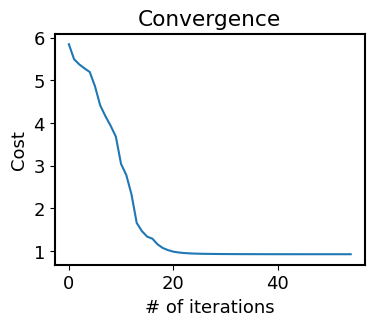

In [254]:
plt.plot(sls.cost_log)
plt.xlabel("# of iterations")
plt.ylabel("Cost")
plt.title("Convergence")

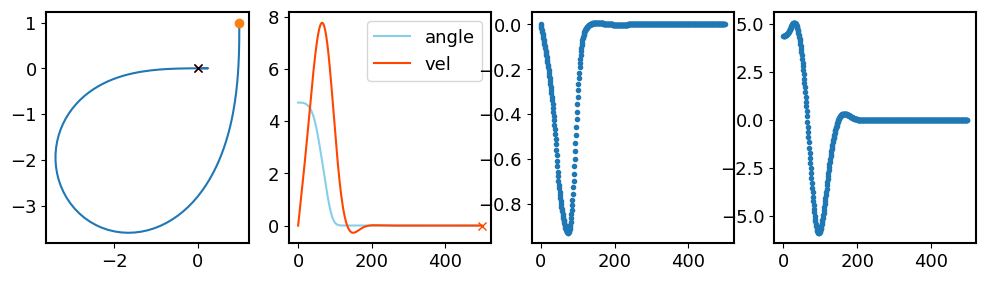

In [284]:
fig,ax = plt.subplots(ncols=4, figsize=(12,3))
ax[0].plot()
ax[0].plot(sls.x_nom[:,0], sls.x_nom[:,1])
ax[0].plot(sls.x_nom[0,0], sls.x_nom[0,1], "o")
ax[0].plot(sls.x_nom[-1,0]*0, sls.x_nom[-1,1]*0, "rx")
ax[0].plot(sls.x_nom[-1,0], sls.x_nom[-1,1], "kx")


ax[1].plot(sls.x_nom[:,2], "skyblue", label="angle")
ax[1].plot(sls.x_nom[:,3], "orangered", label="vel")

# ax[1].plot([N], [0], "x", color= "skyblue")
ax[1].plot([N], [0], "x", color="orangered")

ax[1].legend()

ax[2].plot(sls.u_nom[:-1,0], ".")
ax[3].plot(sls.u_nom[:-1,1],".")

## Solve the constrained problem

### Define constraints

In [262]:
### Control limits
lower_u1 = -.5
upper_u1 = .5

lower_u2 = -2.
upper_u2 = 2.
def project_u(u):
    u_ = u.reshape(N,u_dim).copy()
    u_[:, 0:1] = project_bound(u_[:, 0:1], lower_u1, upper_u1)
    u_[:, 1:2] = project_bound(u_[:, 1:2], lower_u2, upper_u2)
    return u_.flatten()

In [270]:
u0 = np.random.normal(size=(N, u_dim))*0.1
x_nom,u_nom = sls.get_trajectory_batch(x0, u0)
sls.reset()
sls.nominal_values = x_nom, u_nom
sls.cost

5.604686845346455

Iteration number  0 iLQR cost:  5.4680290858199125


C:\Users\hakan\anaconda3\envs\hg\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\hakan\anaconda3\envs\hg\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Iteration number  1 iLQR cost:  5.3866278253825435
Iteration number  2 iLQR cost:  5.365254225323146
Iteration number  3 iLQR cost:  5.312937141567028
Iteration number  4 iLQR cost:  5.292911856852933
Iteration number  5 iLQR cost:  5.217758786969079
Iteration number  6 iLQR cost:  5.155290643832267
Iteration number  7 iLQR cost:  5.064459459398709
Iteration number  8 iLQR cost:  4.936528141794045
Iteration number  9 iLQR cost:  4.888018479096417
Iteration number  10 iLQR cost:  4.842820025480538
Iteration number  11 iLQR cost:  4.7013809397935376
Iteration number  12 iLQR cost:  4.510067251280011
Iteration number  13 iLQR cost:  4.045565451189889
Iteration number  14 iLQR cost:  3.9631753835256722
Iteration number  15 iLQR cost:  3.788810292170172
Iteration number  16 iLQR cost:  3.557220551946587
Iteration number  17 iLQR cost:  3.455854654363975
Iteration number  18 iLQR cost:  3.252356210826457
Iteration number  19 iLQR cost:  3.1250829546953653
Iteration number  20 iLQR cost:  2.9

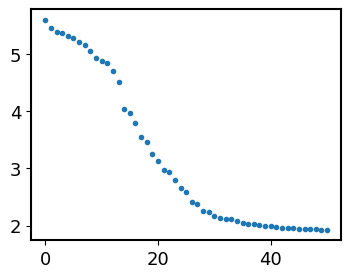

In [272]:
%%time
rho_u = np.diag([1e-1, 1e-2])
max_iter = 50
log = sls.ilqr_admm(get_AB=get_AB, get_Cs=get_Cs, project_u=project_u, max_iter=max_iter, max_admm_iter=5,
                        max_line_search_iter=40, rho_u=rho_u, tol=1e-3, verbose=False, log=True)
plt.plot(sls.cost_log,".")


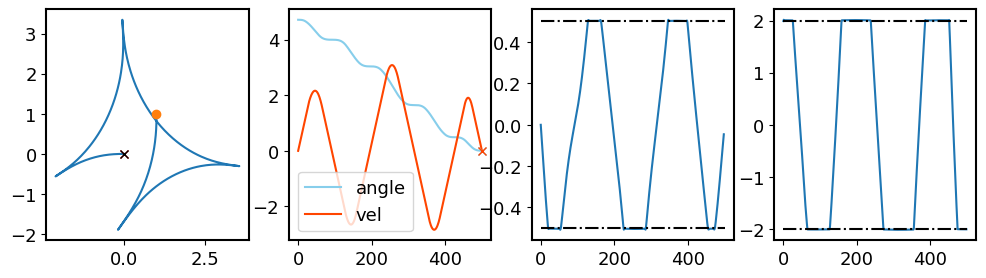

In [269]:
fig,ax = plt.subplots(ncols=4, figsize=(12,3))
ax[0].plot(sls.x_nom[:,0], sls.x_nom[:,1])
ax[0].plot(sls.x_nom[0,0], sls.x_nom[0,1], "o")
ax[0].plot(sls.x_nom[-1,0]*0, sls.x_nom[-1,1]*0, "rx")
ax[0].plot(sls.x_nom[-1,0], sls.x_nom[-1,1], "kx")


ax[1].plot(sls.x_nom[:,2], "skyblue", label="angle")
ax[1].plot(sls.x_nom[:,3], "orangered", label="vel")

ax[1].plot([N], [0], "x", color= "skyblue")
ax[1].plot([N], [0], "x", color="orangered")

ax[1].legend()

ax[2].plot(sls.u_nom[:-1,0], "-")
ax[3].plot(sls.u_nom[:-1,1],"-")
lower_us = [lower_u1, lower_u2]
upper_us = [upper_u1, upper_u2]

for i in range(2):
    ax[2+i].plot([0,N],[lower_us[i]]*2, "-.k")
    ax[i+2].plot([0,N],[upper_us[i]]*2, "-.k")